A EletroPlaza Store é um conglomerado de lojas presente em diversos países do mundo. Apesar da presença online da marca, as vendas são predominantemente físicas. A multinacional atua com eletrônicos, eletrodomésticos e acessórios em geral, oferecendo produtos acessíveis e de qualidade para uma vasta gama de clientes.

Após diversos investimentos realizados nos setores de vendas, marketing e desenvolvimento de produtos, a empresa teve um grande salto em seu faturamento no último ano. Porém, junto ao faturamento, vieram novos desafios em tentar entender precisamente como as vendas vão continuar se comportando nas próximas semanas.

O ano está chegando ao fim e a Black Friday e o Natal estão se aproximando. As vendas tendem a subir exponencialmente ainda mais nessa época e os dados de comparação do ano passado já não servem mais como termômetro para a empresa. Além disso, a equipe de negócio tem uma meta de faturamento e está preocupada se conseguirá alcançá-la. A urgência em entender os possíveis resultados é grande.

O desafio da sua equipe, formada por cientistas e analistas de dados, é construir uma solução que preveja as vendas semanais das lojas e de seus variados setores para as 5 semanas finais do ano. Deste modo, os gestores da EletroPlaza Store poderão definir planos futuros, organizar estoques, calcular receitas, decidir se farão novos investimentos ou não e onde devem alocar estes novos investimentos, através de campanhas mais eficientes de marketing e vendas.

Os dados disponíveis para a previsão são referentes às vendas realizadas do início do ano vigente até o momento. Cada linha representa um setor específico de uma loja específica naquela determinada semana. São fornecidas diversas informações para análise, inclusive dados externos como temperatura, preço de combustível e taxa de desemprego. Ainda, devido a urgência da solicitação, há diversos dados faltantes na base e a sua equipe não tem tempo hábil o suficiente para coletá-los, devendo buscar soluções alternativas para que mesmo assim consiga realizar previsões eficazes.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.feature_selection import RFE

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Load Data

In [4]:
path = '/home/edilson07/projects/hackday_7/data/'

train = pd.read_csv(path + 'train.csv')
train_features = pd.read_csv(path + 'train_features.csv')
stores = pd.read_csv(path + 'stores.csv')

test = pd.read_csv(path + 'test.csv')
test_features = pd.read_csv(path + 'test_features.csv')

df = pd.merge(stores, train_features, on=['loja'], how='left')
df = pd.merge(train, df, on=['loja','data'], how='left')
df = df.drop('feriado_y', axis=1)
df = df.rename(columns={'feriado_x':'feriado'})

df_test = pd.merge(stores, test_features, on=['loja'], how='left')
df_test = pd.merge(test, df_test, on=['loja','data'], how='left')
df_test = df_test.drop('feriado_y', axis=1)
df_test = df_test.rename(columns={'feriado_x':'feriado'})

## Data Description

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135385 entries, 0 to 135384
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      135385 non-null  int64  
 1   loja                    135385 non-null  int64  
 2   setor                   135385 non-null  int64  
 3   data                    135385 non-null  object 
 4   vendas_semanais         122523 non-null  float64
 5   feriado                 135385 non-null  object 
 6   tipo                    135385 non-null  object 
 7   tamanho                 102058 non-null  float64
 8   temperatura             87440 non-null   float64
 9   combustivel             82396 non-null   float64
 10  desconto_1              5926 non-null    float64
 11  desconto_2              5875 non-null    float64
 12  desconto_3              5639 non-null    float64
 13  desconto_4              5201 non-null    float64
 14  desconto_5          

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,135385.0,208371.000000,39082.427434,140679.000000,174525.000000,208371.000000,242217.000000,276063.000000
loja,135385.0,22.210681,12.783303,1.000000,11.000000,22.000000,33.000000,45.000000
setor,135385.0,44.150327,30.451533,1.000000,18.000000,37.000000,72.000000,99.000000
vendas_semanais,122523.0,62991.392230,198445.286559,-1321.480000,2228.580000,8236.320000,23589.140000,999967.424022
tamanho,102058.0,132619.110310,57153.086978,34875.000000,103681.000000,128107.000000,196321.000000,219622.000000
temperatura,87440.0,15.733733,10.735085,-18.922222,8.244444,17.283333,23.388889,37.588889
combustivel,82396.0,3.597816,0.285991,2.891000,3.459000,3.623000,3.807000,4.211000
desconto_1,5926.0,8883.068046,7933.224879,5.640000,3648.400000,6756.030000,10941.050000,34348.140000
desconto_2,5875.0,5213.345593,7754.955048,2.630000,274.850000,1229.960000,7898.330000,44021.610000
desconto_3,5639.0,221.416875,232.376139,1.320000,61.080000,143.880000,292.440000,1134.490000


In [7]:
df.nunique()

id                        135385
loja                          45
setor                         80
data                          46
vendas_semanais           113130
feriado                        2
tipo                           3
tamanho                       31
temperatura                 1056
combustivel                  329
desconto_1                    90
desconto_2                    89
desconto_3                    84
desconto_4                    75
desconto_5                    90
desemprego                   117
distancia_competidores        90
clientes                     867
dtype: int64

## Check NaN

In [8]:
df.isna().sum()

id                             0
loja                           0
setor                          0
data                           0
vendas_semanais            12862
feriado                        0
tipo                           0
tamanho                    33327
temperatura                47945
combustivel                52989
desconto_1                129459
desconto_2                129510
desconto_3                129746
desconto_4                130184
desconto_5                129459
desemprego                     0
distancia_competidores    129459
clientes                       0
dtype: int64

## Change Types

In [9]:
def change_types(df):

    df['data'] = pd.to_datetime(df['data'], format='%m-%d')
    
    df['dia'] = df['data'].dt.day
    df['mes'] = df['data'].dt.month
    df['dia_semana'] = df['data'].dt.dayofweek
    df['trimestre'] = df['data'].dt.quarter
    df['semana_do_ano'] = df['data'].dt.isocalendar().week
    df['dia_ano'] = df['data'].dt.dayofyear

    return df

df = change_types(df)
df_test = change_types(df_test)

In [10]:
# temperatura, combustivel, tamanho - média
fill_temp = df.groupby(['loja'])['temperatura'].transform('mean')
fill_fuel = df['combustivel'].mean()
fill_size = df['tamanho'].mean()

def clean_nan(df, fill_temp, fill_fuel, fill_size, isTrain=True):

    # descontos
    df[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']] = df[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']].fillna(0)

    # temperatura, combustivel, tamanho - média
    df['temperatura'] = df['temperatura'].fillna(fill_temp)
    df['combustivel'] = df['combustivel'].fillna(fill_fuel)
    df['tamanho'] = df['tamanho'].fillna(fill_size)
    
    # distancia_competidores, tamanho
    df['distancia_competidores'] = df['distancia_competidores'].fillna(500_000)

    if isTrain:
        df['vendas_semanais'] = df['vendas_semanais'].fillna(0)

    return df

df = clean_nan(df, fill_temp, fill_fuel, fill_size)
df_test = clean_nan(df_test, fill_temp, fill_fuel, fill_size, isTrain=False)

In [11]:
df = df.dropna()

In [12]:
df_test.isna().sum()

id                        0
loja                      0
setor                     0
data                      0
feriado                   0
tipo                      0
tamanho                   0
temperatura               0
combustivel               0
desconto_1                0
desconto_2                0
desconto_3                0
desconto_4                0
desconto_5                0
desemprego                0
distancia_competidores    0
clientes                  0
dia                       0
mes                       0
dia_semana                0
trimestre                 0
semana_do_ano             0
dia_ano                   0
dtype: int64

In [13]:
df.isna().sum()

id                        0
loja                      0
setor                     0
data                      0
vendas_semanais           0
feriado                   0
tipo                      0
tamanho                   0
temperatura               0
combustivel               0
desconto_1                0
desconto_2                0
desconto_3                0
desconto_4                0
desconto_5                0
desemprego                0
distancia_competidores    0
clientes                  0
dia                       0
mes                       0
dia_semana                0
trimestre                 0
semana_do_ano             0
dia_ano                   0
dtype: int64

## Feature Engineering

In [14]:
#Black Friday e Christmas
black_friday = pd.to_datetime('1900-11-24')
christmas = pd.to_datetime('1900-12-25')
df['days_until_black_friday'] = (black_friday - df['data']).dt.days
df['days_until_christmas'] = (christmas - df['data']).dt.days

df_test['days_until_black_friday'] = (black_friday - df_test['data']).dt.days
df_test['days_until_christmas'] = (christmas - df_test['data']).dt.days

In [15]:
# Promotional Discount features
df['has_promotional_discount'] = (df[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']] > 0).any(axis=1).astype(int)
df_test['has_promotional_discount'] = (df_test[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']] > 0).any(axis=1).astype(int)

In [16]:
df['total_discount'] = df[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']].sum(axis=1)
df_test['total_discount'] = df_test[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']].sum(axis=1)

In [17]:
# Weather-related features
# Assuming you have predefined temperature ranges
temperature_bins = [-np.inf, 10, 20, 30, np.inf]
temperature_labels = ['very_cold', 'cold', 'moderate', 'hot']
df['temperature_category'] = pd.cut(df['temperatura'], bins=temperature_bins, labels=temperature_labels)
df_test['temperature_category'] = pd.cut(df_test['temperatura'], bins=temperature_bins, labels=temperature_labels)

In [18]:
# Competitor-related features
df['normalized_distance_competitors'] = (df['distancia_competidores'] - df['distancia_competidores'].mean()) / df['distancia_competidores'].std()
df_test['normalized_distance_competitors'] = (df_test['distancia_competidores'] - df_test['distancia_competidores'].mean()) / df_test['distancia_competidores'].std()

df['has_competitors'] = (df['normalized_distance_competitors'] > 0).astype(int)
df_test['has_competitors'] = (df_test['normalized_distance_competitors'] > 0).astype(int)

In [19]:
# Customer-related features
df['customer_density'] = df['clientes'] / df['tamanho']
df_test['customer_density'] = df_test['clientes'] / df_test['tamanho']

In [20]:
# Interaction features
df['temperature_clients_interaction'] = df['temperatura'] * df['clientes']
df_test['temperature_clients_interaction'] = df_test['temperatura'] * df_test['clientes']

In [21]:
# Drop unnecessary columns
columns_to_drop = ['data', 'distancia_competidores', 'clientes']
df = df.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)

In [22]:
df.head()

,id,loja,setor,vendas_semanais,feriado,tipo,tamanho,temperatura,combustivel,desconto_1,...,dia_ano,days_until_black_friday,days_until_christmas,has_promotional_discount,total_discount,temperature_category,normalized_distance_competitors,has_competitors,customer_density,temperature_clients_interaction
0,140679,17,93,6283.00,nao,eletronico,93188.00000,-14.316667,2.891000,0.0,...,7,321,352,0,0.0,very_cold,0.213844,1,0.005805,-7745.316667
1,140680,12,17,10006.77,nao,eletronico,112238.00000,3.133333,3.287000,0.0,...,7,321,352,0,0.0,very_cold,0.213844,1,0.004125,1450.733333
2,140681,3,25,2658.57,nao,eletronico,132619.11031,11.861111,3.597816,0.0,...,7,321,352,0,0.0,cold,0.213844,1,0.006794,10686.861111
3,140682,42,1,8836.00,nao,outro,39690.00000,21.900831,3.597816,0.0,...,7,321,352,0,0.0,moderate,0.213844,1,0.004434,3854.546177
4,140683,26,9,9526.27,nao,eletrodomestico,152513.00000,-6.038889,3.193000,0.0,...,7,321,352,0,0.0,very_cold,0.213844,1,0.000813,-748.822222


# Pre Processing

## One Hot Encoding

In [23]:
feriados = {'nao' : 0,
            'sim': 1}

temp_cat = {'very_cold':0,
           'cold':1,
           'moderate':2,
           'hot':3}

def make_feriados(feriados, df):

    df['feriado'] = df['feriado'].map(feriados)
    df = pd.get_dummies(df, prefix=['tipo'], columns=['tipo'])
    df['temperature_category'] = df['temperature_category'].map(temp_cat).astype(int)
    

    return df

df = make_feriados(feriados, df)
df_test = make_feriados(feriados, df_test)



In [24]:
df.head()

,id,loja,setor,vendas_semanais,feriado,tamanho,temperatura,combustivel,desconto_1,desconto_2,...,has_promotional_discount,total_discount,temperature_category,normalized_distance_competitors,has_competitors,customer_density,temperature_clients_interaction,tipo_eletrodomestico,tipo_eletronico,tipo_outro
0,140679,17,93,6283.00,0,93188.00000,-14.316667,2.891000,0.0,0.0,...,0,0.0,0,0.213844,1,0.005805,-7745.316667,False,True,False
1,140680,12,17,10006.77,0,112238.00000,3.133333,3.287000,0.0,0.0,...,0,0.0,0,0.213844,1,0.004125,1450.733333,False,True,False
2,140681,3,25,2658.57,0,132619.11031,11.861111,3.597816,0.0,0.0,...,0,0.0,1,0.213844,1,0.006794,10686.861111,False,True,False
3,140682,42,1,8836.00,0,39690.00000,21.900831,3.597816,0.0,0.0,...,0,0.0,2,0.213844,1,0.004434,3854.546177,False,False,True
4,140683,26,9,9526.27,0,152513.00000,-6.038889,3.193000,0.0,0.0,...,0,0.0,0,0.213844,1,0.000813,-748.822222,True,False,False


In [25]:
df.dtypes

id                                   int64
loja                                 int64
setor                                int64
vendas_semanais                    float64
feriado                              int64
tamanho                            float64
temperatura                        float64
combustivel                        float64
desconto_1                         float64
desconto_2                         float64
desconto_3                         float64
desconto_4                         float64
desconto_5                         float64
desemprego                         float64
dia                                  int32
mes                                  int32
dia_semana                           int32
trimestre                            int32
semana_do_ano                       UInt32
dia_ano                              int32
days_until_black_friday              int64
days_until_christmas                 int64
has_promotional_discount             int64
total_disco

In [26]:
df.columns

Index(['id', 'loja', 'setor', 'vendas_semanais', 'feriado', 'tamanho',
       'temperatura', 'combustivel', 'desconto_1', 'desconto_2', 'desconto_3',
       'desconto_4', 'desconto_5', 'desemprego', 'dia', 'mes', 'dia_semana',
       'trimestre', 'semana_do_ano', 'dia_ano', 'days_until_black_friday',
       'days_until_christmas', 'has_promotional_discount', 'total_discount',
       'temperature_category', 'normalized_distance_competitors',
       'has_competitors', 'customer_density',
       'temperature_clients_interaction', 'tipo_eletrodomestico',
       'tipo_eletronico', 'tipo_outro'],
      dtype='object')

## Time Scaling

In [27]:
def time_scaling(df):

    # dia
    df['dia_sin'] = df['dia'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
    df['dia_cos'] = df['dia'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )
    
    # mes
    df['month_sin'] = df['mes'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
    df['month_cos'] = df['mes'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )
    
    # dia_semana
    df['dia_semana_sin'] = df['dia_semana'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
    df['dia_semana_cos'] = df['dia_semana'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )
    
    # trimestre
    df['trimestre_sin'] = df['trimestre'].apply( lambda x: np.sin( x * ( 2 * np.pi/4 ) ) )
    df['trimestre_cos'] = df['trimestre'].apply( lambda x: np.cos( x * ( 2 * np.pi/4 ) ) )
    
    # semana_do_ano
    df['semana_do_ano_sin'] = df['semana_do_ano'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
    df['semana_do_ano_cos'] = df['semana_do_ano'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )
    
    # dia_ano
    df['dia_ano_sin'] = df['dia_ano'].apply( lambda x: np.sin( x * ( 2 * np.pi/365 ) ) )
    df['dia_ano_cos'] = df['dia_ano'].apply( lambda x: np.cos( x * ( 2 * np.pi/365 ) ) )

    return df

df_test = time_scaling(df_test)
df = time_scaling(df)

## Feature Importance

In [28]:
X = df.drop(['vendas_semanais'], axis=1)
y = df['vendas_semanais']

In [29]:
rf = RandomForestRegressor(n_jobs=-1)

rf.fit(X, y)

RandomForestRegressor(n_jobs=-1)

<Axes: xlabel='Importância', ylabel='Feature'>

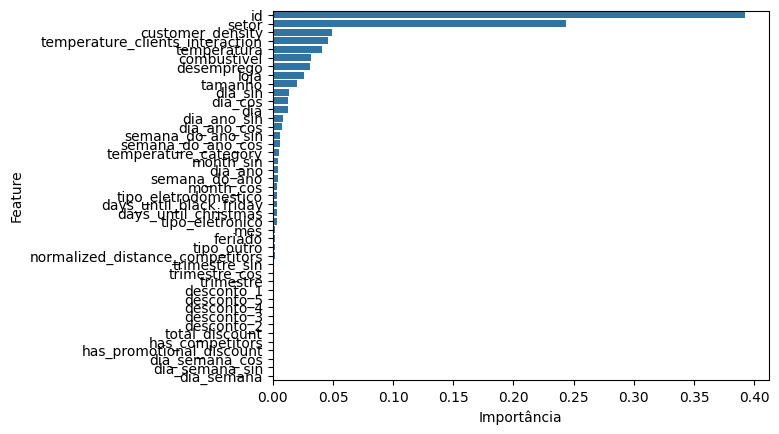

In [30]:
importances = rf.feature_importances_

colunas = X.columns

ranking_imp = pd.DataFrame({'Feature': colunas, 'Importância':importances}).sort_values(by='Importância',ascending=False)

sns.barplot(ranking_imp, x='Importância', y='Feature', orient='horizontal')

## RFE

In [32]:
rfe = RFE(rf, verbose=2)

rfe.fit(X, y)

Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.


RFE(estimator=RandomForestRegressor(n_jobs=-1), verbose=2)

In [34]:
# Obtém as colunas selecionadas
selected_columns = pd.DataFrame(rfe.support_, index=X.columns, columns=['Selected'])
selected_columns = selected_columns[selected_columns['Selected']].index.tolist()

print("Colunas selecionadas pelo RFE:")
print(selected_columns)

Colunas selecionadas pelo RFE:
['id', 'loja', 'setor', 'tamanho', 'temperatura', 'combustivel', 'desemprego', 'dia', 'semana_do_ano', 'days_until_black_friday', 'temperature_category', 'customer_density', 'temperature_clients_interaction', 'tipo_eletrodomestico', 'dia_sin', 'dia_cos', 'month_sin', 'semana_do_ano_sin', 'semana_do_ano_cos', 'dia_ano_sin', 'dia_ano_cos']


In [37]:
cols_selected = ['id', 
                 'loja', 
                 'setor', 
                 'tamanho', 
                 'temperatura', 
                 'combustivel', 
                 'desemprego', 
                 'dia', 
                 'semana_do_ano', 
                 'days_until_black_friday', 
                 'temperature_category', 
                 'customer_density', 
                 'temperature_clients_interaction', 
                 'tipo_eletrodomestico', 
                 'dia_sin', 
                 'dia_cos', 
                 'month_sin', 
                 'semana_do_ano_sin', 
                 'semana_do_ano_cos', 
                 'dia_ano_sin', 
                 'dia_ano_cos']

X = X[cols_selected]
df_test = df_test[cols_selected]

# Machine Learning

## Split train-val

In [38]:
time_split = TimeSeriesSplit(n_splits=5)

## Regressão Linear

In [40]:
def reg_metrics(y_true, y_pred, model):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    df = pd.DataFrame({
        'Model': model.__name__,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse,
        'RMSE': rmse,
    }, index=[0])
    
    return df

def cross_val_ts(X, y, time_split, model):

    rmse = cross_val_score(model(), X, y, cv=time_split, scoring='neg_mean_squared_error')
    print(rmse)
    rmse = np.sqrt(abs(rmse.mean()))

    

    return pd.DataFrame({
        'Model': model.__name__,
        'RMSE CV': rmse
    }, index=[0])

In [135]:
lr = LinearRegression()

#for train_index, test_index in time_split.split(df):
#    train_dates = df['semana_do_ano'].iloc[train_index]
#    test_dates = df['semana_do_ano'].iloc[test_index]
#    
#    print("Conjunto de Treinamento Datas:", train_dates.min(), "a", train_dates.max())
#    print("Conjunto de Teste Datas:", test_dates.min(), "a", test_dates.max())
#    print("\n")

lr_metrics = cross_val_ts(X, y, time_split, LinearRegression)

[-4.12540009e+10 -4.35383837e+10 -3.74647180e+10 -3.56040724e+10
 -3.43401136e+10]


## XGBoost

In [118]:
xgb = XGBRegressor()

xgb_metrics = cross_val_ts(X, y, time_split, XGBRegressor)

## Catboost

In [119]:
cat = CatBoostRegressor()

cat_metrics = cross_val_ts(X, y, time_split, CatBoostRegressor)

Learning rate set to 0.066992
0:	learn: 187559.2088930	total: 50.5ms	remaining: 50.5s
1:	learn: 187519.8491387	total: 53.3ms	remaining: 26.6s
2:	learn: 187466.3106518	total: 59.4ms	remaining: 19.7s
3:	learn: 187408.7233583	total: 62.1ms	remaining: 15.5s
4:	learn: 187376.1557221	total: 65ms	remaining: 12.9s
5:	learn: 187337.2527855	total: 67.4ms	remaining: 11.2s
6:	learn: 187307.3834236	total: 70.6ms	remaining: 10s
7:	learn: 187258.6663529	total: 73.8ms	remaining: 9.15s
8:	learn: 187214.9404541	total: 77.2ms	remaining: 8.5s
9:	learn: 187180.2056384	total: 79.5ms	remaining: 7.87s
10:	learn: 187146.9119144	total: 81.8ms	remaining: 7.35s
11:	learn: 187112.4735664	total: 86.5ms	remaining: 7.12s
12:	learn: 187076.1749685	total: 89.6ms	remaining: 6.8s
13:	learn: 187048.5295424	total: 92.8ms	remaining: 6.54s
14:	learn: 187008.5980078	total: 97.3ms	remaining: 6.39s
15:	learn: 186975.4591965	total: 102ms	remaining: 6.25s
16:	learn: 186940.9536326	total: 105ms	remaining: 6.06s
17:	learn: 186904.0

## LIGHTBM

In [41]:
lgb = LGBMRegressor(verbose=-1)

lgb_metrics = cross_val_ts(X, y, time_split, LGBMRegressor)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 22565, number of used features: 21
[LightGBM] [Info] Start training from score 55657.892170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1508
[LightGBM] [Info] Number of data points in the train set: 45129, number of used features: 21
[LightGBM] [Info] Start training from score 57091.180772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 67693, number of used features: 21
[LightGBM] [Info] S

## LASSO

In [121]:
lasso = Lasso(alpha=0.1)

lasso_metrics = cross_val_ts(X, y, time_split, Lasso)

/home/edilson07/.pyenv/versions/3.10.11/envs/hackday_7/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.952e+14, tolerance: 7.942e+10
  model = cd_fast.enet_coordinate_descent(
/home/edilson07/.pyenv/versions/3.10.11/envs/hackday_7/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.164e+14, tolerance: 1.635e+11
  model = cd_fast.enet_coordinate_descent(
/home/edilson07/.pyenv/versions/3.10.11/envs/hackday_7/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the nu

## Ridge

In [122]:
ridge = Ridge()

ridge_metrics = cross_val_ts(X, y, time_split, Ridge)

## Elastic Net

In [123]:
elastic = ElasticNet()

elastic_metrics = cross_val_ts(X, y, time_split, ElasticNet)

/home/edilson07/.pyenv/versions/3.10.11/envs/hackday_7/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.952e+14, tolerance: 7.942e+10
  model = cd_fast.enet_coordinate_descent(
/home/edilson07/.pyenv/versions/3.10.11/envs/hackday_7/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.166e+14, tolerance: 1.635e+11
  model = cd_fast.enet_coordinate_descent(
/home/edilson07/.pyenv/versions/3.10.11/envs/hackday_7/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the nu

In [124]:
pd.concat([lgb_metrics, lr_metrics, cat_metrics, xgb_metrics, lasso_metrics, elastic_metrics, ridge_metrics])

,Model,RMSE CV
0,LGBMRegressor,190925.253961
0,LinearRegression,196061.872185
0,CatBoostRegressor,195729.773371
0,XGBRegressor,211067.486036
0,Lasso,190574.921748
0,ElasticNet,190066.669845
0,Ridge,190569.701560


## Final Model

In [42]:
lgb.fit(X, y)

y_pred = lgb.predict(df_test)

# Submission

In [43]:
X_test = pd.merge(stores, test_features, on=['loja'], how='left')
X_test = pd.merge(test, X_test, on=['loja','data'], how='left')
X_test = X_test.drop('feriado_y', axis=1)
X_test = X_test.rename(columns={'feriado_x':'feriado'})

In [44]:
X_test['vendas_semanais'] = y_pred
df_submission = X_test[['id','vendas_semanais']]

In [45]:
df_submission.to_csv('nona_lgb_feature_engineering.csv', index=False)

In [46]:
df_submission

,id,vendas_semanais
0,276064,48570.067568
1,276065,47429.385077
2,276066,49961.531536
3,276067,124374.769997
4,276068,46706.455286
...,...,...
18063,294127,76272.748648
18064,294128,47791.248118
18065,294129,72682.571481
18066,294130,68821.317558
